# Main Cleaning Process and Exploration Analysis
**This notebook serves as the main data cleaning and processing module**

In this notebook , I will 
1. Combine all the diagnosis records from different sections.
2. Implement the chronological filtering to determine the earliest date of pre-diabetes and diabetes. 
3. Merge with demographic information and calculate the age of each time point(pre, diab, death)
4. Exclude some invalid records and label the patients.
5. Do the exploration analysis where I will give out the basic statistic and plot various of charts to illustrate the basic demographic outlines.

For clarity: we name all the pre-diabetes patients with prefix pre,diabetes patients with prefix diab and the patients progressed from pre-diabetes to diabetes with prefix pre2Diab.

We also label the abnormal patients as follow:
- Pre-diabetes Patient (Only have pre-diabetes): 0
- Pre-diabetes to Diabetes paitient (the patients who has sign of pre-diabetes BEFORE they are diagosed with diabetes): 1
- Diabetes (Only have diabetes or have earlier confirmed as diabetes than pre-diabetes): 2

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
import datetime
import random
import time
import shap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
from typing import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
COLORS = [
    "#F27970",
    "#BB9727",
    "#54B345",
    "#32B897",
    "#05B9E2",
    "#8983BF",
    "#C76DA2"
]

COLORS
COLOR_MAP = shap.plots.colors.red_blue

# 0 Generate Pseudo Data

In [8]:
FEATURES = {
    "lab_tests" : ["hba1c", "fasting_glucose", "creatinine", "ldl_c", "hdl_c", "triglyceride", "potassium"],
    "demographic" : ["age", "sex"]
}

## 1. Combine All The Records From Different  Sections

We read all the table we want from disk:
- Lab Test result
- Diagnosis result (Diabetes Only)
- Family Medicine
- DMCS
- Medication (drug)

In [9]:
file_path = r'../tables/output'

# read the diag result from each tables
lab_diag = pd.read_csv(r'../tables/output/first_diag_lab.csv', index_col=0)
dx_diag = pd.read_csv(r'../tables/output/first_diag_dx.csv', index_col=0)
fm_diag = pd.read_csv(r'../tables/output/first_diag_fm.csv', index_col=0)
dmcs_diag = pd.read_csv(r'../tables/output/first_diag_dmcs.csv', index_col=0)
drug_diag = pd.read_csv(r'../tables/output/first_diag_drug.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../tables/output/first_diag_lab.csv'

In [ ]:
# combine the diagnosis together
combine = pd.concat([lab_diag, dx_diag, fm_diag, dmcs_diag, drug_diag]).reset_index(drop=True)
combine

In [ ]:
# convert the data type
combine["diff_hour"] = combine["diff_hour"].astype('int')

## 2. Implement the Chronological Filtering

Now, we got the patient diagnosis of pre-diabetes and diabetes for every patient. we need to seperate them into three groups:
1. group 0: no pre-diabetes or diabetes records were earlier than pre-diabetes
2. group 1: only pre-diabetes
3. group 2: pre-diabetes to diabetes

In [ ]:
start = time.time()

def chronoFilter(df: pd.DataFrame) -> pd.DataFrame:
    '''
    callable object than can apply splittng rules that define each patient labels on each patient records. The splitting 
    rules are defined as follow:
    - Pre-diabetes Patient (Only have pre-diabetes): 0
    - Pre-diabetes to Diabetes paitient (the patients who has sign of pre-diabetes BEFORE they are diagosed with diabetes): 1
    - Diabetes (Only have diabetes or have earlier confirmed as diabetes than pre-diabetes): 2
    
    Args:
        df: grouped data frame that is waiting to be aggregated
    Return:
        aggregated data frame
    
    '''
    
    dim = df.shape[0]
    assert dim <= 2 # make sure there are only earliest record(s) in this dataframe
    
    # one record only situation
    if dim == 1: 
        if df.iloc[0]["diab_type"] == "pre":
            return pd.DataFrame({
                "pseudo_patient_key":[df.iloc[0,0]], 
                "pre_dtm": [df.iloc[0,1]],
                "diab_dtm": [np.nan],
                "pre_diff_hour": [df.iloc[0,2]],
                "diab_diff_hour": [np.nan],
                "pre_src": [df.iloc[0,4]],
                "diab_src":[np.nan],
                "label": [0]
            })
        else: #diabetes
            return pd.DataFrame({
            "pseudo_patient_key":[df.iloc[0,0]], 
            "pre_dtm": [np.nan], 
            "diab_dtm": [df.iloc[0,1]],
            "pre_diff_hour": [np.nan],
            "diab_diff_hour": [df.iloc[0,2]],
            "pre_src": [np.nan],
            "diab_src":[df.iloc[0,4]],
            "label": [2]
        })
        
    # two records situation
    else: 
        if df.iloc[0]["diff_hour"] > df.iloc[1]["diff_hour"]: # pre to diabetes
            return pd.DataFrame({
            "pseudo_patient_key":[df.iloc[0,0]], 
            "pre_dtm": [df.iloc[1,1]], 
            "diab_dtm": [df.iloc[0,1]],
            "pre_diff_hour": [df.iloc[1,2]],
            "diab_diff_hour": [df.iloc[0,2]],
            "pre_src": [df.iloc[1,4]],
            "diab_src":[df.iloc[0,4]],
            "label": [1]
        })
        else: # diabetes to pre
            return pd.DataFrame({
            "pseudo_patient_key":[df.iloc[0,0]], 
            "pre_dtm": [np.nan], 
            "diab_dtm": [df.iloc[0,1]],
            "pre_diff_hour": [np.nan],
            "diab_diff_hour": [df.iloc[0,2]],
            "pre_src": [np.nan],
            "diab_src":[df.iloc[0,4]],
            "label": [2]
        })

        
#######################################################################################
# get the row number 
rnk = tools.row_number(combine, "pseudo_patient_key", "diab_type", sort_key="diff_hour")
# get the earliest records for each patient each diab type
el_rec = combine[rnk == 1].sort_values(["pseudo_patient_key", "diab_type"])
# apply the rules on the dataframe
group_patient = el_rec.groupby(by="pseudo_patient_key").apply(chronoFilter)
# write the data to disk
group_patient.to_csv("../tables/output/group_patient.csv")

min = (time.time() - start) / 60
print("runtime: {:.4f} minutes".format(min))

## 3. Merge with demographic information and test results.

### 3.1 Demographic Infomation

In [ ]:
# read the file of patient demographic information
patient_info = tools.fileReader(r"../DATAFILE", 'patient_data')
# read the grouped patients
group_patient = pd.read_csv(r"../tables/output/group_patient.csv", index_col=0)

In [ ]:
left = group_patient
right = patient_info[["pseudo_patient_key", "dob_Y", "sex", "death_date_Y", "diff_in_hour_death_date"]]
diab_patients_info = pd.merge(left=left, right=right, how='left', on='pseudo_patient_key')

Get the age of each date time.

In [ ]:
def map_age(df, fields, dob="dob_Y"):
    '''
    map the date time fieds into age inplace
    Args:
        field: date fields
        dob: date of birth
    '''
        
    age_fields = list(map(lambda x : x.split(r'_')[0] + "_age", fields))
    for af, f in zip(age_fields, fields):
        df[af] = (pd.to_datetime(df[f]) - pd.to_datetime(df[dob])).apply(lambda x : x / np.timedelta64(1, "Y"))
        
######################################################################################################################  

# replace null value to np.nan
diab_patient_age = diab_patients_info.replace(r'""', np.nan)
# map the date time fields into age inplace
map_age(diab_patient_age, ["pre_dtm", "diab_dtm", "death_date_Y"])

# Generate Pseudo patient data

In [10]:
def generate_random_date(start_year=2003, end_year=2019):
    # Generate a random date within the specified range
    start_date = datetime.date(start_year, 1, 1)
    end_date = datetime.date(end_year, 12, 31)
    days_between = (end_date - start_date).days
    random_days = random.randint(0, days_between)
    random_date = start_date + datetime.timedelta(days=random_days)
    return random_date.strftime('%Y-%m-%d')

In [11]:
N = 10000
data = {}
for lt in FEATURES["lab_tests"]:
    low = np.random.randint(0,100)
    data[lt] = [np.random.uniform(low, low+20) if np.random.uniform(0, 1) > np.random.uniform(0, 1) * 0.5 else np.nan for _ in range(N)]
    
data["age"] = np.random.uniform(18, 120, N)
data["sex"] = (np.random.uniform(0, 1, N) < 0.45).astype("int")
data["diab_diff_hour"] = np.random.randint(1000,10000, N)
data["diff_in_hour_death_date"] = [np.random.randint(10000, 15000) if np.random.uniform(0, 1) < 0.2 else np.nan for _ in range(N)]
data["pre_diff_hour"] = data["diab_diff_hour"] - np.random.randint(100, 1000)
data["dob_Y"] = np.random.randint(1965, 1996, N).astype("str")
data["label"] = np.random.randint(0, 3, N)
data["pre_dtm"] = [generate_random_date() for _ in range(N)]
data["pre_age"] = map(lambda x : int(x[:4]), data["pre_dtm"])
diab_patient_age = pd.DataFrame(data)

## 4 Exclusion and Labeling

### 4.1 Exclusion
exclusion criterial:
 - Enrolment in last {{TIME_SPEC}} (pre_dtm <= {{CUT_OFF}})
 - Follow up time is less than {{TIME_SPEC}}, we want to exclude the patients who exited the investigation out of death.
 - Diabetes only.
 - Patients younger than 18 (pre_age < 18)

In [12]:
# convert to year of birth
diab_patient_age["dob_Y"] = diab_patient_age["dob_Y"].apply(lambda x : x[:4]).astype("int")
# compute the progression period in hours
diab_patient_age["prog_pd"] = diab_patient_age["diab_diff_hour"] - diab_patient_age["pre_diff_hour"] 
diab_patient_age["diff_in_hour_death_date"] = diab_patient_age["diff_in_hour_death_date"].astype("float")

In [13]:
MIN_FT = 30.5 * 24
# exclusion

def show_num():
    print("total: ", diab_patient_excluded.shape[0], 
    "label 0: ", diab_patient_excluded.query("label == 0").shape[0], 
    "label 1: ", diab_patient_excluded.query("label == 1").shape[0]
    )
    
diab_patient_excluded = diab_patient_age.copy() # create a new reference

show_num()
# we first exclude the patients with label 2(diabetes before pre-diabetes)
diab_patient_excluded = diab_patient_excluded.query("~(label == 2)")
show_num()
# we exclude the patients who died before possibly diagnosed with T2DM
diab_patient_excluded = diab_patient_excluded.query("~(label == 0 and diff_in_hour_death_date.notnull())")
show_num()
# we exclude the patients who exit the cohort before possibly diagnosed with T2DM
TIME_SPEC = 10
CUT_OFF = '{year}-12-31'.format(year=2019-TIME_SPEC)
diab_patient_excluded = diab_patient_excluded.query("~(label == 0 and pre_dtm > '{CUT_OFF}')")
show_num()
# Patients younger than 18(pre_age < 18)
diab_patient_excluded = diab_patient_excluded.query("pre_age >= 18")
show_num()

# # Follow-up time less than 1 month i.e. 30.5*24 hours
# diab_patient_age = diab_patient_age.query(f"prog_pd > {MIN_FT} | prog_pd.isnull()", engine='python')

total:  10000 label 0:  3266 label 1:  3407
total:  6673 label 0:  3266 label 1:  3407
total:  6025 label 0:  2618 label 1:  3407
total:  6025 label 0:  2618 label 1:  3407
total:  6025 label 0:  2618 label 1:  3407


### 4.2 Labeling

In [14]:
# diab_patient_age = diab_patient_age.assign(prog_pd = diab_patient_age["diab_diff_hour"] - diab_patient_age["pre_diff_hour"])
year_hours = 24 * 365.25
def cls_mapper(prog_pd: float) -> int:
    if prog_pd < 2 * year_hours:
        return 0
    elif prog_pd < 5 * year_hours:
        return 1
    elif prog_pd < 10 * year_hours:
        return 2
    return 3

# uncomment it in the HA
# diab_patient_excluded["cls"] = diab_patient_excluded["prog_pd"].apply(cls_mapper)
diab_patient_excluded["cls"] = np.random.randint(0, 4, diab_patient_excluded.shape[0])

## 5. Explanatory Analysis
I will plot distribution plot 

In [15]:
# define helper functions
def plot_barchart(s:pd.Series, n_bin:int, bin_width:int=1, sort=False, title=""):
    bin = pd.cut(s, bins=[bin_width * i for i in range(n_bin)])
    out = bin.value_counts(sort=sort)
    ax = out.plot.bar(rot=0, color='b', figsize=(6,4))
    ax.set_xticklabels([bin_width * x for x in range(n_bin)])
    ax.set_title(title)

def plot_boxplot(df, cat, title):
    # boxplot for death age
    fig, axs = plt.subplots(1,len(cat))
    fig.suptitle(title)
    for idx, name in zip(range(len(cat)), cat):
        data = df[df.label == idx]["death_age"]
        axs[idx].boxplot(data, 0, '')
        axs[idx].set_title(name)
    

def show_number(df):
    tools.getNum(df, False)

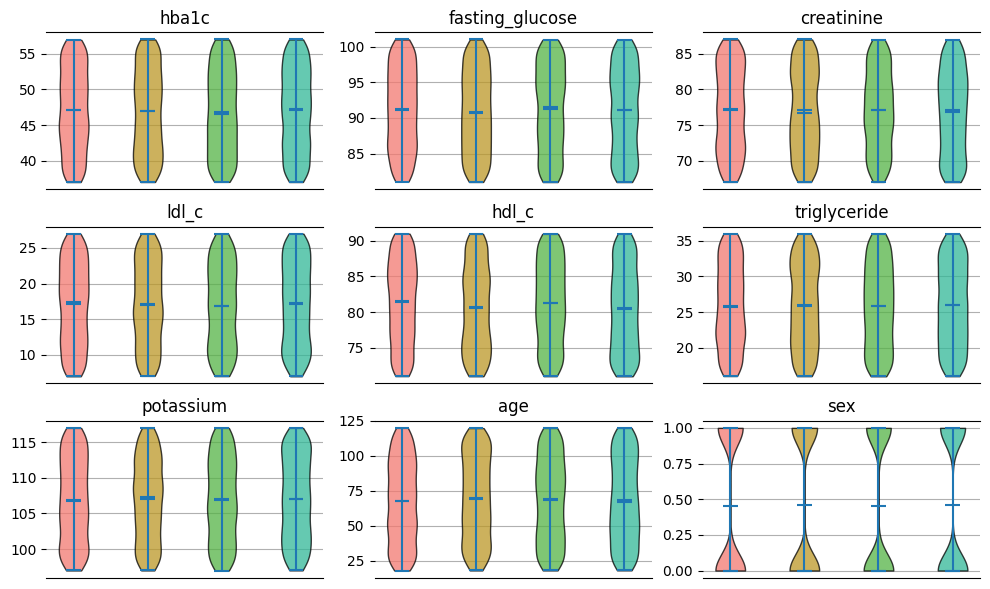

In [50]:
def plot_violin(df: pd.DataFrame, features, cls="cls"):
    # Define a list of colors, assuming COLORS variable is defined somewhere globally.
    # If not, define it as a list of matplotlib color codes.
 

    # Create the figure and axes object
    classes = df[cls].unique()
    
    n = len(features) // 3 + (len(features) % 3 > 0)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(10, 6))
    for i, feature in enumerate(features):
        
        row = i // 3
        col = i % 3
        data = []
        ax = axs[row, col]
        ax.grid(True)
        ax.set_axisbelow(True)
        for cl in classes:
            data.append(df[df[cls] == cl][feature].dropna().values)
        


        # Create violin plot
        parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True,  widths=0.4)

        # Coloring each violin
        for pc, color in zip(parts['bodies'], COLORS[:len(classes)]):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(0.75)

        # Setting labels for x-ticks
        ax.set_xticks([])
        # ax.set_xticklabels(classes)
        ax.set_title(feature)

        # Removing y-axis labels for clarity if many plots are drawn
        ax.set_ylabel('')
        ax.set_xlabel('')
        # ax.spines['top'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # Adjust layout
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

features = []
features.extend(FEATURES["lab_tests"])
features.extend(FEATURES["demographic"])
plot_violin(diab_patient_excluded, features)

In [52]:
diab_patient_excluded["cls"]

0       0
1       2
2       1
3       0
4       1
       ..
9988    3
9989    0
9991    3
9996    3
9997    1
Name: cls, Length: 6025, dtype: int64

In [26]:
diab_patient_excluded.head(100).to_csv("example.csv")

In [27]:
diab_patient_excluded

,hba1c,fasting_glucose,creatinine,ldl_c,hdl_c,triglyceride,potassium,age,sex,diab_diff_hour,diff_in_hour_death_date,pre_diff_hour,dob_Y,label,pre_dtm,pre_age,prog_pd,cls
0,NaN,82.092718,71.799165,15.704518,73.334956,NaN,110.180813,28.291390,0,5662,NaN,5410,1988,0,2008-12-29,2008,252,0
1,40.618375,NaN,75.119850,21.742229,NaN,34.263407,NaN,80.195582,1,6148,12140.0,5896,1978,1,2011-09-25,2011,252,2
2,47.448315,98.783986,68.465512,23.249408,85.724567,21.587370,108.864004,72.700665,0,6043,NaN,5791,1966,0,2012-08-23,2012,252,1
3,40.023112,90.280974,73.251039,18.052756,78.891886,22.173395,99.075477,20.613289,0,6070,NaN,5818,1976,0,2012-04-23,2012,252,0
4,43.510601,99.416122,72.499159,NaN,NaN,33.365295,109.314706,22.937233,1,5382,NaN,5130,1992,1,2003-07-26,2003,252,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,45.950026,97.911644,72.306814,11.835875,73.173343,NaN,113.016583,28.485260,0,3433,NaN,3181,1987,1,2012-03-20,2012,252,3
9989,53.004603,99.512312,NaN,NaN,NaN,22.284197,NaN,101.621977,1,1122,NaN,870,1986,1,2014-04-22,2014,252,0
9991,55.883888,93.196939,81.397554,21.116863,NaN,35.306310,NaN,65.968800,0,1278,NaN,1026,1987,0,2017-01-10,2017,252,3
9996,56.913365,84.721269,NaN,18.072680,90.295559,31.728618,NaN,40.285433,1,8642,NaN,8390,1973,0,2012-07-23,2012,252,3


In [21]:
FEATURES

{'lab_tests': ['hba1c',
  'fasting_glucose',
  'creatinine',
  'ldl_c',
  'hdl_c',
  'triglyceride',
  'potassium'],
 'demographic': ['age', 'sex']}

### 5.1 BoxPlot

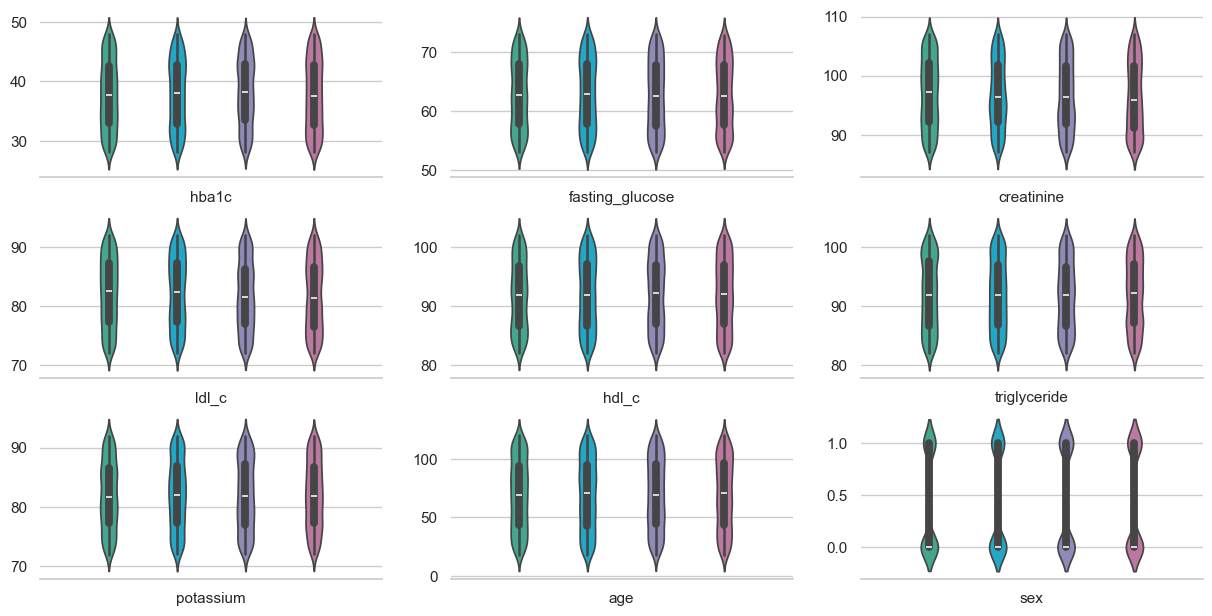

In [69]:
# violin plot
def plot_box(df: pd.DataFrame, features: Sequence[str], cls="cls"):

    # Create the figure and axes object
    fig = plt.figure(figsize=(15, 10))
    n = len(features) // 3 + 1
    for i, feature in enumerate(features):
        df_melted = df[[feature, cls]].melt(id_vars=cls, value_vars=feature,
                        var_name="Measurements", value_name="Value")
        ax = plt.subplot(n, 3, i+1)

        # Creating the violin plot on the axes object
        colors = {}
        for i, color in enumerate(COLORS):
            colors[i] = color

        sns.despine(left=True)
        ax = sns.violinplot(x="Measurements", y="Value", hue="cls", data=df_melted, palette=colors, gap=0.75)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.legend().set_visible(False)


features = []
features.extend(FEATURES["lab_tests"])
features.extend(FEATURES["demographic"])

plot_box(diab_patient_excluded, features)
fig.subplots_adjust(hspace=0.4)

In [21]:
diab_patient_excluded

,hba1c,fasting_glucose,creatinine,ldl_c,hdl_c,triglyceride,potassium,age,sex,diab_diff_hour,diff_in_hour_death_date,pre_diff_hour,dob_Y,label,pre_dtm,pre_age,prog_pd,cls
0,NaN,69.401066,103.500419,80.044641,99.784313,82.050629,83.143501,69.229695,0,6493,NaN,6340,1974,0,2003-08-11,2003,153,0
1,29.045186,NaN,97.116556,80.190784,NaN,100.297907,82.299258,45.803298,0,9551,10477.0,9398,1979,1,2013-08-24,2013,153,1
3,NaN,66.147811,106.956766,NaN,97.744271,99.169031,80.507175,25.941504,0,5143,NaN,4990,1983,1,2003-06-05,2003,153,1
4,NaN,72.667599,99.553031,90.885809,100.436053,98.146304,87.884007,109.671004,1,3793,NaN,3640,1980,1,2015-04-02,2015,153,1
6,29.337677,61.476507,NaN,82.149724,90.680668,96.553420,86.147341,47.532510,0,9406,NaN,9253,1982,1,2019-10-06,2019,153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,NaN,53.872260,NaN,72.958402,NaN,86.012230,NaN,64.939495,0,9963,NaN,9810,1977,1,2011-10-06,2011,153,1
9995,47.879920,62.025852,94.882924,72.735607,84.900021,84.907968,82.683856,83.160919,0,4601,NaN,4448,1981,1,2008-02-29,2008,153,0
9996,46.654658,NaN,103.286067,NaN,85.320804,NaN,NaN,65.404569,0,3368,NaN,3215,1973,0,2014-04-05,2014,153,1
9997,32.399791,53.039711,101.884281,NaN,101.676490,NaN,85.992615,109.476723,1,7097,11639.0,6944,1972,1,2011-09-29,2011,153,1


### 5.2 Correlation Plot

<Figure size 1000x800 with 0 Axes>

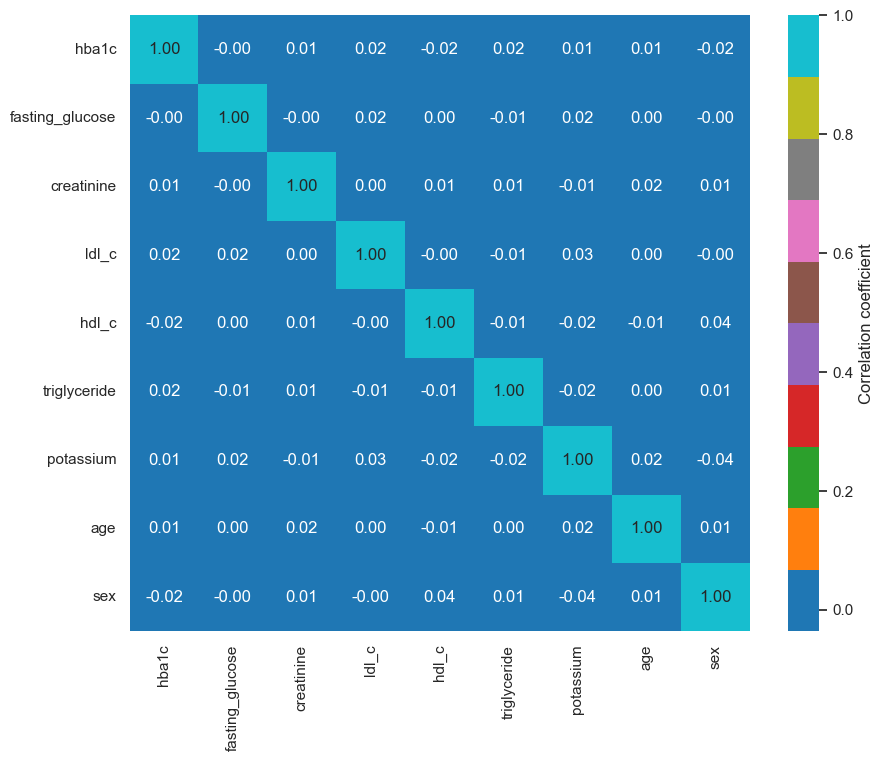

In [72]:
plt.figure(figsize=(10, 8))
corr_matrix = diab_patient_excluded[features].corr()
# Set up the matplotlib figure
_ = plt.figure(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="tab10", cbar_kws={'label': 'Correlation coefficient'})
plt.savefig("correlation_plot.svg", format="svg", dpi=700)

In [22]:
import pandas as pd
from scipy.stats import kruskal, chi2_contingency
import scipy.stats as stats
# Load the dataset


# Define the features and the group
features = ["hba1c", "fasting_glucose", "creatinine", "ldl_c", "hdl_c", "triglyceride", "potassium", "age", "sex"]

group = 'cls'

statistics = ["missing_rate",
    "pvalue",
    "g0_mean",
    "g1_mean",
    "g2_mean",
    "g3_mean",
    "g0_std",
    "g1_std",
    "g2_std",
    "g3_std",
    "g0_iqr",
    "g1_iqr",
    "g2_iqr",
    "g3_iqr",
]

class StatTape():

    missing_rate = []
    pvalue = []

    g0_mean = []
    g1_mean = []
    g2_mean = []
    g3_mean = []

    g0_std = []
    g1_std = []
    g2_std = []
    g3_std = []

    g0_iqr = []
    g1_iqr = []
    g2_iqr = []
    g3_iqr = []

def stat_append(name: str, value: Any):
    getattr(StatTape, name).append(value)

for feature in features:
    # perform chi square test
    stat_append("missing_rate", diab_patient_excluded[feature].isnull().mean())
    if feature == "sex":
        table = []
        for label in [0,1,2,3]:
            female = diab_patient_excluded.query(f"cls == {label} and sex == 0").count()
            male = diab_patient_excluded.query(f"cls == {label} and sex == 1").count()
            table.append([female, male])
        pvalue = chi2_contingency(table).pvalue
    else:
        groups = diab_patient_excluded.groupby(group)[feature].apply(list)
        pvalue = kruskal(*groups, nan_policy="omit").pvalue

    stat_append("pvalue", pvalue)

    for label in [0, 1, 2, 3]:
        temp = diab_patient_excluded.query(f"cls == {label}")[feature]
        mean = temp.mean()
        std = temp.std()
        iqr = stats.iqr(temp.to_list(), nan_policy="omit")
        stat_append(f"g{label}_mean", mean)
        stat_append(f"g{label}_std", std)
        stat_append(f"g{label}_iqr", iqr)

d = {"features": features}
for s in statistics:
    d[s] = getattr(StatTape, s)
feature_stats = pd.DataFrame(d)

In [23]:
dataset = diab_patient_excluded.copy() # create new reference

## 5.3 Handling Missingness

I will handle the missingness following steps:
1. exclude the patients without HbA1c, Fasting Glucose.
2. drop the variables that exceeds 30% missingness over the remaining population.
3. check the missingness mechanism, and impute using MICE.
4. mssingness not at random(MNAR) is ruled out from the discussion the given the natural of the clinical input.


In [74]:
# exclude the patients without HbA1c, Fasting Glucose
dataset = dataset.query("hba1c.notnull() and fasting_glucose.notnull()", engine="python")

# drop the variables that exceeds 25% missingness over the remaining population.
mask = dataset[features].isnull().mean() < 0.25
valid_features = dataset[features].columns[mask].to_list()

In [62]:
# check the missing mechanism
def hold_out(name, targets):
    res = []
    for target in targets:
        if target != name:
            res.append(target)
    return res

def check_mm(valid_features, df, alpha=0.05):
    '''
    check the missing assumption
    '''
    res = {}
    for target in valid_features:
        remain_feature = hold_out(target, targets)
        ds = df.copy()
        if ds[target].isnull().sum() == 0:
            res[target] = np.nan
            continue 

        dummy = ds[target].isnull().astype(bool)
        table = []
        for label in [0,1,2,3]:
            miss = ds[dummy].query(f"cls == {label}")[target].shape[0]
            non_miss = ds[~dummy].query(f"cls == {label}")[target].shape[0]
            table.append([miss, non_miss])
            
        result = chi2_contingency(table).pvalue
        res[target] = "significant" if result < alpha else "non-significant"
    return res

check_mm(valid_features, dataset)

{'hba1c': nan,
 'fasting_glucose': nan,
 'ldl_c': 'non-significant',
 'hdl_c': 'non-significant',
 'potassium': 'non-significant',
 'age': nan,
 'sex': nan}

### Imputation
a rule of thumb for determining the number of
mputations is to use at least the percentage of incomplete cases or more[1].

The imputation should also be implemented within cross-validation[2].

[1] Bodner, T. E. (2008). What improves with increased missing data imputations?. Structural equation modeling: a multidisciplinary journal, 15(4), 651-675.

[2] https://missingdatasolutions.rbind.io/2021/02/mi-cross-validation/

In [75]:
valid_features

['hba1c', 'fasting_glucose', 'ldl_c', 'hdl_c', 'potassium', 'age', 'sex']

In [76]:
label_and_features = valid_features
label_and_features.append("cls")
dataset[label_and_features].to_csv("dataset.csv", index=False)

In [4]:
from sklearn import metrics

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

metrics.f1_score(y_true, y_pred, average='weighted')

0.26666666666666666